<a href="https://colab.research.google.com/github/karanamrahul/END-Course-NLP/blob/Assignment-4/Capstone%20Project%20END%20Phase-1/Python_code_generation_using_Natural_Language_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Capstone Project** : Create a Transformer based model to generate Python code snippets from natural language with proper indentations and white space.

**Dataset**
We have a dataset of 4600+ examples of english text based questions with python code snippets.



Import the neccesary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy import data
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

The below code is used to generate random seed which will maintain the randomness till kernel is functional.

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [4]:
spacy_en = spacy.load('en')

#**Data Pre-processing**


**Dataset Examples**

```

  Question: 
  # Write a Python program to calculate distance between two points using latitude and longitude.
  
  Answer:
from math import radians, sin, cos, acos

print("Input coordinates of two points:")
slat = radians(float(input("Starting latitude: ")))
slon = radians(float(input("Ending longitude: ")))
elat = radians(float(input("Starting latitude: ")))
elon = radians(float(input("Ending longitude: ")))

dist = 6371.01 * acos(sin(slat)*sin(elat) + cos(slat)*cos(elat)*cos(slon - elon))
print("The distance is %.2fkm." % dist)

Question: 
# Write a Python class to convert a roman numeral to an integer.

Answer:
class Solution:
    def roman_to_int(self, s):
        rom_val = {'I': 1, 'V': 5, 'X': 10, 'L': 50, 'C': 100, 'D': 500, 'M': 1000}
        int_val = 0
        for i in range(len(s)):
            if i > 0 and rom_val[s[i]] > rom_val[s[i - 1]]:
                int_val += rom_val[s[i]] - 2 * rom_val[s[i - 1]]
            else:
                int_val += rom_val[s[i]]
        return int_val



```









1.   Dataset is a txt file containing natural language(English) questions with python code snippets.

2.   Questions begin with # | # 01 | Just the question. Answer will be the next line or all the following lines will be considered as pyhton code.
First step in preprocessing is to divide them into question and answer pairs and then tokenize both of them seperately.

*   English text will be tokenized using spacy tokenizer but for the pyhton code we need create a seperate tokenizer as syntax for python code will be different.

*   We need to replace \n as << new_line>> and for ' ' as <space> so that the tokenization will be easy and can be stored.







In [5]:
df= []
temp = {'question':'','answer':''}
with open ('english_python_data.txt', 'r') as openfile:
  lines = openfile.readlines ()
  #print (line)
for line in lines:
  #print (line)
  try:
    if line[0] == '#' or line[1] == '#':
      df.append (temp)
      temp = {'question':'','answer':''}
      temp['question'] = line.replace ('\n', '')
    else:
      temp['answer'] += line.replace ('\n', '<new_line>').replace (' ', '<space>').replace ('"', "'")
  except:
    pass

In [6]:
df[277]

{'input': '# Write a function to return the total surface area of a cuboid of length l, bredth b and height h',
 'output': 'def<space>cal_surface_area_cuboid(l,b,h):<new_line><space><space><space><space>return<space>2*(l*b+b*h+h*l)<new_line>'}

Split and Store the data in a csv format for eeasy read.

In [7]:
df_len= len (datas)
test_data = int (df_len * 0.8)
val_data= int (df_len * 0.9)
train = datas
val = datas[test_data:val_data]
test = datas[val_data:]

counter = 0
with open ('train.csv', 'w') as openfile:
  for element in train:
    if element['question'] == '' or element['answer'] == '':
      continue
    openfile.write ('"' + element['input'] + '","' + element['answer'] + '"\n')
with open ('val.csv', 'w') as openfile:
  for element in val:
    if element['question'] == '' or element['answer'] == '':
      continue
    openfile.write ('"' + element['input'] + '","' + element['answer'] + '"\n')
with open ('test.csv', 'w') as openfile:
  for element in test:
    if element['question'] == '' or element['answer'] == '':
      continue
    openfile.write ('"' + element['question'] + '","' + element['answer'] + '"\n')

In [8]:
!head train.csv

"# write a python program to add two numbers ","num1<space>=<space>1.5<new_line>num2<space>=<space>6.3<new_line>sum<space>=<space>num1<space>+<space>num2<new_line>print(f'Sum:<space>{sum}')<new_line>"
"# write a python function to add two user provided numbers and return the sum","def<space>add_two_numbers(num1,<space>num2):<new_line><space><space><space><space>sum<space>=<space>num1<space>+<space>num2<new_line><space><space><space><space>return<space>sum<new_line>"
"# write a program to find and print the largest among three numbers","num1<space>=<space>10<new_line>num2<space>=<space>12<new_line>num3<space>=<space>14<new_line>if<space>(num1<space>>=<space>num2)<space>and<space>(num1<space>>=<space>num3):<new_line><space><space><space>largest<space>=<space>num1<new_line>elif<space>(num2<space>>=<space>num1)<space>and<space>(num2<space>>=<space>num3):<new_line><space><space><space>largest<space>=<space>num2<new_line>else:<new_line><space><space><space>largest<space>=<space>num3<new_line

We need to create tokenizer for both english and pyhton.

We need to split the code wherever we find the following:
points = [**<space>**, **:**, **<new_line>**, **(**, **)**, **[**, **]**, **>**, **<**, **=**, **'**, **"**, **.**, **%**, **+**, **-**, *, **\t**, **{**, **}**, **/**]

The above 

In [9]:
def tokenize_python (line):
  points = ['<space>', ':', '<new_line>', '(', ')', '[', ']', '>', '<', '=', "'", '"', '.', '%', ',', '+', '-', '*', '\t', '{', '}', '/']

  words = []
  temp = ''
  n = len(line)
  i = 0

  while i < n:
    #print (i, line[i], temp, words)
    if line[i:i+7] == '<space>':
      if temp != '':
        words.append (temp)
        temp = ''
      words.append ('<space>')
      i = i + 7

    elif line[i:i+10] == '<new_line>':
      if temp != '':
        words.append (temp)
        temp = ''
      words.append ('<new_line>')
      i = i + 10

    elif line[i] in split_points:
      if temp != '':
        words.append (temp)
        temp = ''
      words.append (line[i])
      i += 1
    else:
      temp += line[i]
      i += 1
  return words

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [10]:
lenn = 0
for element in datas:
  if element['input'] == '':
    continue
  #print (element, len(element['output']))
  #print (tokenize_de (element['output']))
  lenn = max (lenn, len(tokenize_de (element['output'])))
print (lenn)

1556


In [11]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_pyhton, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [12]:
train_data, valid_data, test_data = data.TabularDataset.splits(
        path='/content/', train='train.csv',
        validation='val.csv', test='test.csv', format='csv',
        fields=[('src', SRC), ('trg', TRG)])

In [13]:
for element in valid_data:
  print (element.trg)
  break

['diff', '<space>', '=', '<space>', '100', '<space>', '-', '<space>', 'int', '(', 'age', ')', '<new_line>']


In [14]:
SRC.build_vocab(train_data, min_freq = 1)
TRG.build_vocab(train_data, min_freq = 1)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [16]:
BATCH_SIZE = 12
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

#**Model Definition**

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-encoder.png)

In [17]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 1700):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [18]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-attention.png)

In [19]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [20]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/transformer-decoder.png)

In [21]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 1700):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [22]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [23]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [24]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [25]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 8,150,741 trainable parameters


In [27]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [28]:
model.apply(initialize_weights);

In [29]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [30]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)


In [31]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()   
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        #print (i, batch)
        src = batch.src
        trg = batch.trg
        #print (i, src, trg)
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [32]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [33]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#**Train for 50 epochs**

In [34]:
N_EPOCHS = 50
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    #valid_loss = evaluate(model, valid_iterator, criterion)
    valid_loss = evaluate(model, train_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 36s
	Train Loss: 2.924 | Train PPL:  18.615
	 Val. Loss: 2.199 |  Val. PPL:   9.012
Epoch: 02 | Time: 0m 37s
	Train Loss: 2.118 | Train PPL:   8.318
	 Val. Loss: 1.808 |  Val. PPL:   6.097
Epoch: 03 | Time: 0m 37s
	Train Loss: 1.825 | Train PPL:   6.201
	 Val. Loss: 1.534 |  Val. PPL:   4.635
Epoch: 04 | Time: 0m 38s
	Train Loss: 1.619 | Train PPL:   5.049
	 Val. Loss: 1.341 |  Val. PPL:   3.825
Epoch: 05 | Time: 0m 37s
	Train Loss: 1.442 | Train PPL:   4.228
	 Val. Loss: 1.186 |  Val. PPL:   3.273
Epoch: 06 | Time: 0m 37s
	Train Loss: 1.302 | Train PPL:   3.678
	 Val. Loss: 1.042 |  Val. PPL:   2.836
Epoch: 07 | Time: 0m 38s
	Train Loss: 1.180 | Train PPL:   3.255
	 Val. Loss: 0.935 |  Val. PPL:   2.548
Epoch: 08 | Time: 0m 38s
	Train Loss: 1.085 | Train PPL:   2.959
	 Val. Loss: 0.826 |  Val. PPL:   2.285
Epoch: 09 | Time: 0m 37s
	Train Loss: 0.994 | Train PPL:   2.702
	 Val. Loss: 0.739 |  Val. PPL:   2.094
Epoch: 10 | Time: 0m 37s
	Train Loss: 0.919 | Train PPL

In [35]:
model.load_state_dict(torch.load('model.pt'))

test_loss = evaluate(model, train_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 0.125 | Test PPL:   1.133 |


In [36]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 1700):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    #return ''.join (trg_tokens[1:]).replace ('<space>', ' ').replace ('<new_line>', '\n').replace ('<eos>'), attention
    return trg_tokens[1:], attention

In [46]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(100,100))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

**Below is an example for the above trained model**

In [48]:
example_idx = 19

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['#', 'write', 'a', 'python', 'function', 'to', 'remove', 'all', 'the', 'odd', 'numbers', 'from', 'a', 'list', 'and', 'return', 'the', 'remaining', 'list']
trg = ['def', '<space>', 'remove_odd', '(', 'my_list', ')', ':', '<new_line>', '<space>', '<space>', '<space>', '<space>', 'result', '<space>', '=', '<space>', 'list', '(', 'filter', '(', 'lambda', '<space>', 'x', ':', '<space>', '(', 'x', '<space>', '%', '<space>', '2', '<space>', '=', '=', '<space>', '0', ')', ',', '<space>', 'my_list', ')', ')', '<new_line>', '<space>', '<space>', '<space>', '<space>', 'return', '<space>', 'result', '<new_line>']


In [49]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

#translation = ''.join (translation).replace ('<space>', ' ').replace ('<new_line>', '\n')
print (''.join (translation).replace ('<space>', ' ').replace ('<new_line>', '\n').replace ('<eos>', ''))

def remove_odd(my_list):
    result = list(filter(lambda x: (x % 2 != 0), my_list))
    return result



The below code will give the correlation or the attention matrix between the natural language and the python output.

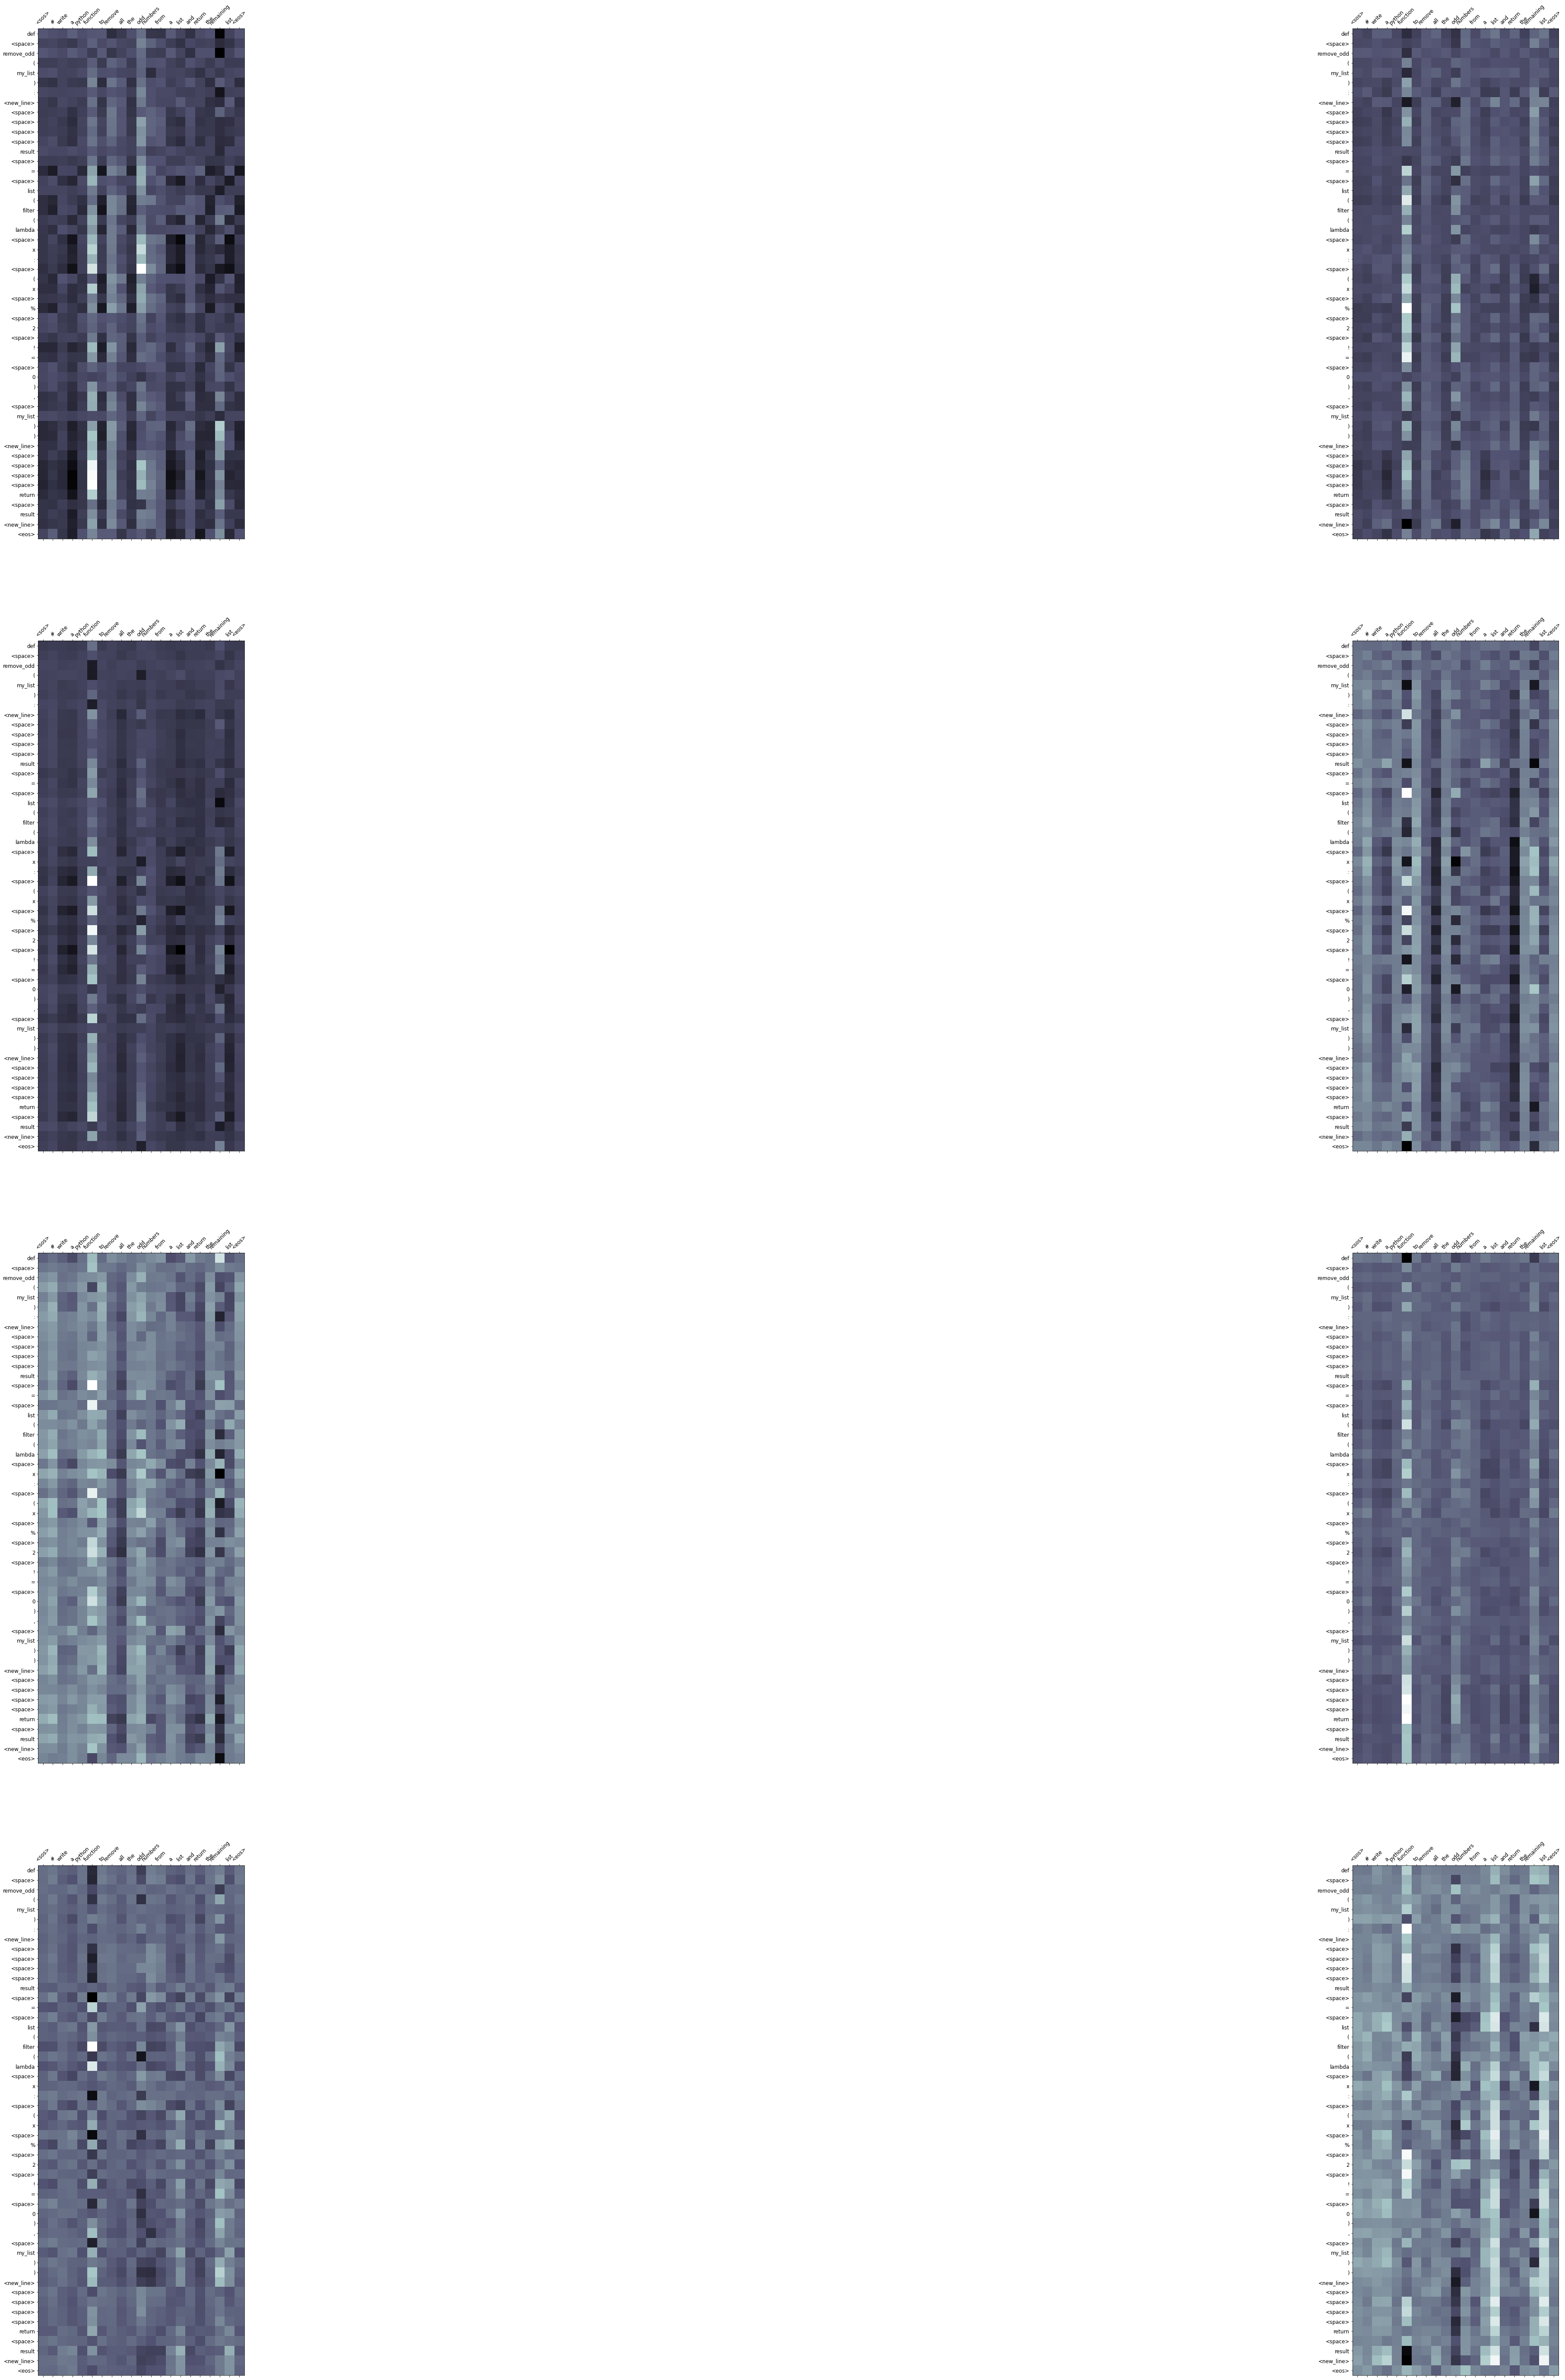

In [50]:
display_attention(src, translation, attention)


In [54]:
example_idx = 124
src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = [' ', '#', 'write', 'a', 'python', 'function', 'to', 'check', 'whether', 'the', 'given', 'number', 'is', 'a', 'buzz', 'number', 'or', 'not']
trg = ['<space>', '<new_line>', '<space>', 'def', '<space>', 'isbuzz', '(', 'num', ')', '<space>', ':', '<space>', '<new_line>', '<space>', '<space>', '<new_line>', '<space>', '<space>', '<space>', '<space>', 'return', '<space>', '(', 'num', '<space>', '%', '<space>', '10', '<space>', '=', '=', '<space>', '7', '<space>', 'or', '<space>', 'num', '<space>', '%', '<space>', '7', '<space>', '=', '=', '<space>', '0', ')', '<space>', '<space>', '<new_line>', '<space>', '<space>', '<new_line>']


In [55]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['<space>', '<new_line>', '<space>', 'def', '<space>', 'isbuzz', '(', 'num', ')', '<space>', ':', '<space>', '<new_line>', '<space>', '<space>', '<new_line>', '<space>', '<space>', '<space>', 'return', '<space>', '(', 'num', '<space>', '%', '<space>', '10', '<space>', '=', '=', '<space>', '7', '<space>', 'or', '<space>', 'num', '<space>', '%', '<space>', '7', '<space>', '=', '=', '<space>', '0', ')', '<space>', '<new_line>', '<space>', '<space>', '<new_line>', '<eos>']


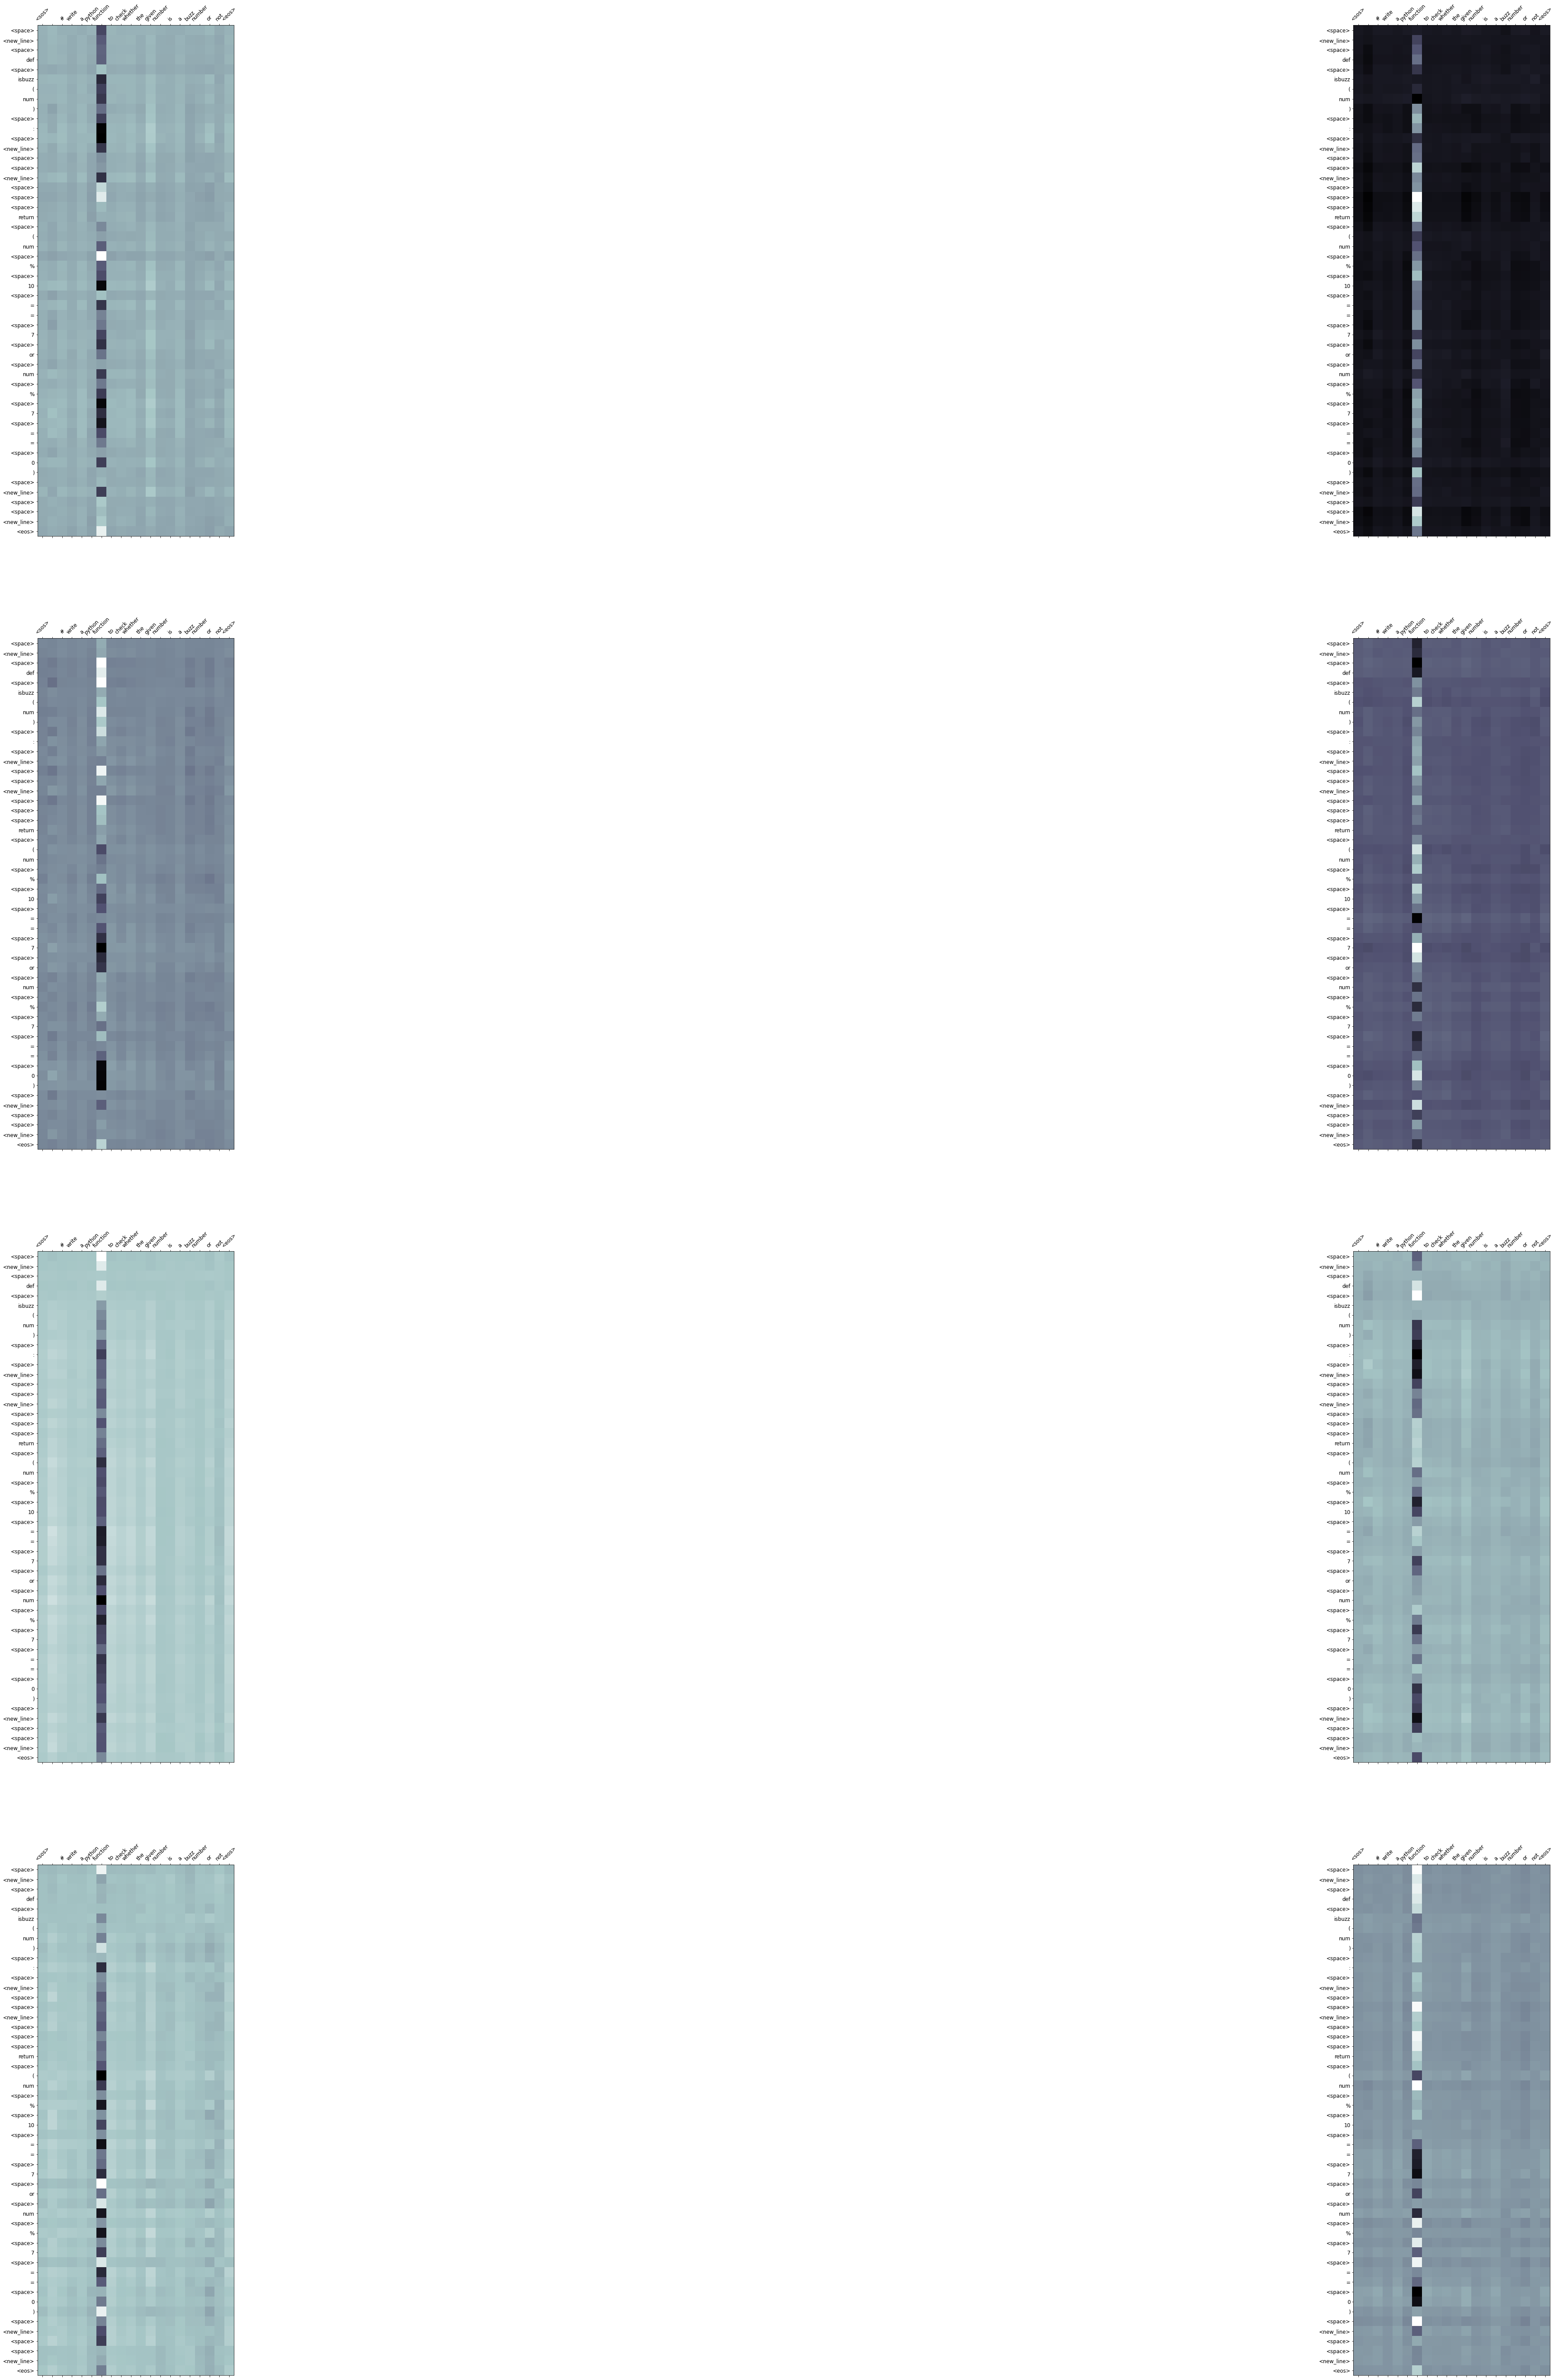

In [56]:
display_attention(src, translation, attention)


#**Examples from the trained model**

We have considered to showcase 25 examples.

The model worked well for the below examples and it turns out to be that this model might not work well on new data as this dataset has lesser examples and it needs to trained at much longer duration with much more examples.

Tagging and tokenizing should be improved to get better accuracy.



In [57]:
from random import randint
example_idxs = [randint(0, 350) for i in range (25)]
for example_idx in example_idxs:
  src = vars (train_data.examples[example_idx])['src']
  trg = vars (train_data.examples[example_idx])['trg']
  print ('problem statement:')
  print (' '.join (src))
  print ('truth:')
  print (''.join (trg).replace ('<space>', ' ').replace ('<new_line>', '\n'))
  print ('prediction:')
  translation, attention = translate_sentence(src, SRC, TRG, model, device)
  print (translation)

problem statement:
# write a function to adds two lists element wise only if numbers are even
truth:
def adds_listevenelements(l1:list, l2:list):
    return [i+j for i, j in zip(l1,l2) if i*j%2 == 0]

prediction:
['def', '<space>', 'adds_listevenelements', '(', 'l1', ':', 'list', ',', '<space>', 'l2', ':', 'list', ')', ':', '<new_line>', '<space>', '<space>', '<space>', '<space>', 'return', '<space>', '[', 'i', '+', 'j', '<space>', 'for', '<space>', 'i', ',', '<space>', 'j', '<space>', 'in', '<space>', 'zip', '(', 'l1', ',', 'l2', ')', '<space>', 'if', '<space>', 'i', '*', 'j', '%', '2', '<space>', '=', '=', '<space>', '1', ']', '<new_line>', '<eos>']
problem statement:
# python function to print all time when angle between hour hand and minute
truth:
def printtime(theta):
    for hh in range(0, 12):
        for mm in range(0, 60):
            if (calcangle(hh, mm) == theta):
                print(hh, ':', mm, sep='')
                return
    print('input angle not valid.')
    retur

In [58]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 1700):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append(''.join (trg).replace ('<space>', ' ').replace ('<new_line>', '\n'))
    print ('done')
    print (pred_trgs[0])
    print (trgs[0])
    return bleu_score(pred_trgs, trgs)